# Regression: Solutions to the exercises

## Supernovae distance modulus: part 1 

Supernova exercise - Fit with linear and polynomial model ; evaluate the best model using the methods seens above

- First, explore fitting this data with Linear and polynomial regression (+ basis function?)
    *  Start from linear regression and polynomial regression
    *  For the case of  polynomial regression, just fit many of them for now.
    * Let's bet based on intuition! Which fit is the best?
    * In what cases are you underfitting the data?
    * In what cases are you overfitting the data?
- Now split the data into training and validation sets
    * Implement a cross-validation procedure
    * Pick the best!
- Does it agree with our bets?

(35.0, 50.0)

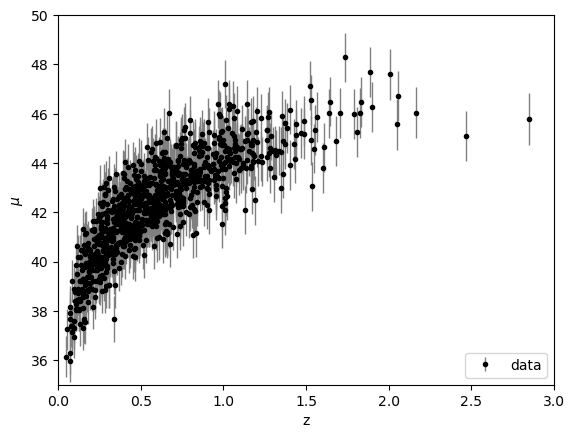

In [2]:
from astroML.datasets import generate_mu_z
import numpy as np 
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression

z_sample, mu_sample, dmu = generate_mu_z(1000, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,3)
plt.ylim(35,50)

First, explore fitting this data with Linear and polynomial regression 

    *  Start from linear regression and polynomial regression
    *  For the case of  polynomial regression, just fit many of them for now.


(35.0, 50.0)

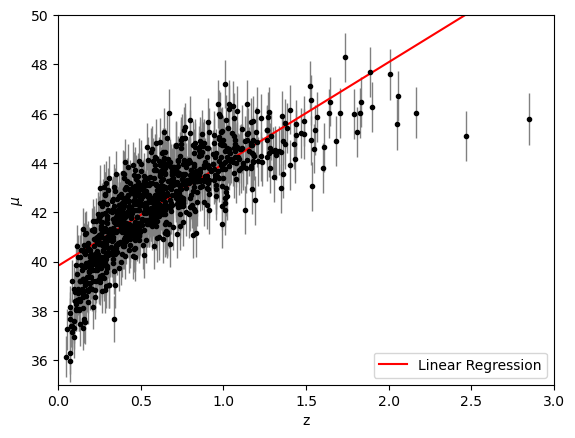

In [3]:
regressor = LinearRegression()
regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)

z = np.linspace(0.01, 3, 1000) # I evaluate the model on a finer grid than the data
mu_fit = regressor.predict(z[:,np.newaxis])

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.plot(z, mu_fit, '-r',label='Linear Regression')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,3)
plt.ylim(35,50)

(35.0, 50.0)

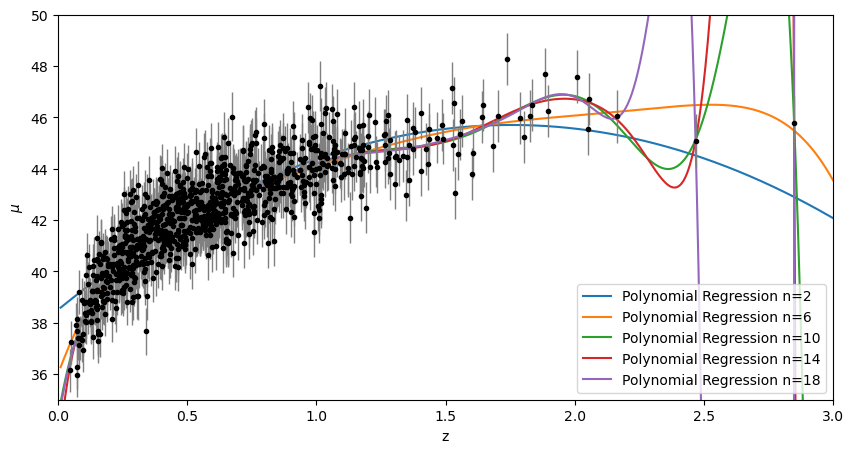

In [4]:
# Now, polynomial regression
f, ax = plt.subplots(figsize = (10,5))
for n in np.arange(1,20)[1::4]:

    regressor = PolynomialRegression(n)
    regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Polynomial Regression n='+str(n))


plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,3)
plt.ylim(35,50)

Fits between order 6 and 10 seems good although likely biased at high z ... Order 1 is underfitting ; order 14 / 18 are likely overfitting. 

(35.0, 50.0)

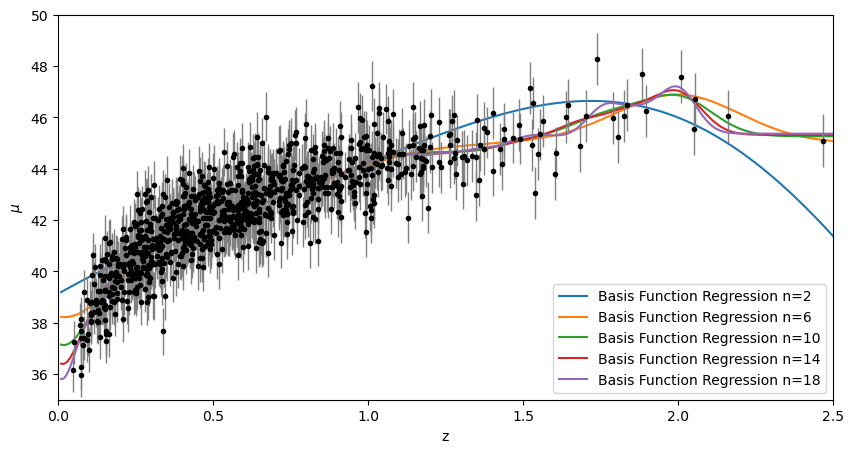

In [5]:
# Gaussian Basis function
from astroML.linear_model import BasisFunctionRegression
f, ax = plt.subplots(figsize = (10,5))
for n in np.arange(1,20)[1::4]:

    basis_mu = np.linspace(0,2,n)[:, None]
    basis_sigma = 0.5 * (basis_mu[1] - basis_mu[0])

    regressor = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_fit = regressor.predict(z[:,np.newaxis])
   
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Basis Function Regression n='+str(n))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2.5)
plt.ylim(35,50)


(35.0, 50.0)

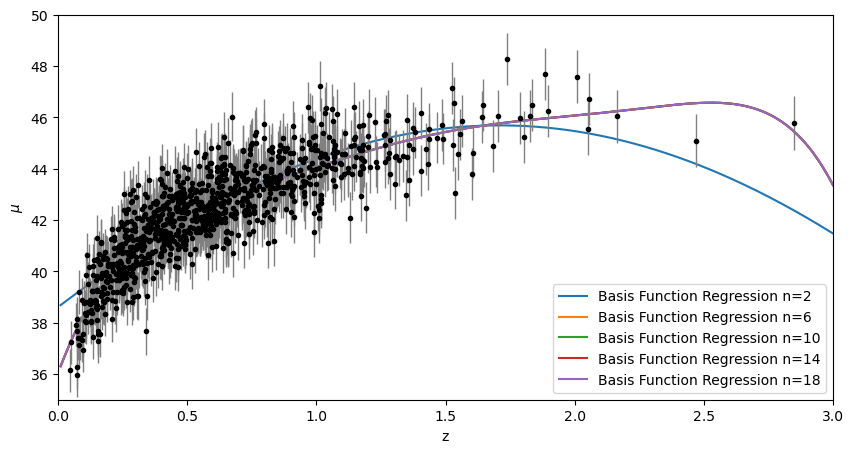

In [6]:
# We can also do it with a gaussian width independent of the number of basis functions
from astroML.linear_model import BasisFunctionRegression
f, ax = plt.subplots(figsize = (10,5))
for n in np.arange(1,20)[1::4]:

    basis_mu = np.linspace(0,2,n)[:, None]
    basis_sigma = 3.0 

    regressor = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_fit = regressor.predict(z[:,np.newaxis])
   
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Basis Function Regression n='+str(n))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,3)
plt.ylim(35,50)


The behaviour is smoother with gaussian basis functions but the arbitrary choice of the gaussian properties is not scientifically not very satisfactory. It could however be acceptable in a different context where a purely empirical model is fine.  

## Find the best order ! 

Let'make the split train / CV "by hand". In cells below, we do it using sklearn function. 

In [8]:
# Let's split the data into training and cv to evaluate under/over fitting / what is the best model

xall, yall = z_sample.copy(), mu_sample.copy()
frac = 0.3 # sample that I reserve for cv (here I do not take test set, but this is debatable)
n_train = int((1.-frac) * len(xall))
n_cv = len(xall) - n_train
#ids = np.arange(len(xall))  # ids of the full data array 
#id_train = np.random.choice(ids, n_train, replace=False)
#id_cv = np.setdiff1d(ids, id_train )
np.random.seed(42)
ids = np.arange(len(xall))
np.random.shuffle(ids)     # Shuffled ids of the full data array; SHUFFLING in place 
id_train = ids[:n_train]   # training ids
id_cv = ids[n_train:]     # remaining of the sample
x_train, y_train = xall[id_train][:,np.newaxis].copy(), yall[id_train].copy()
x_cv, y_cv = xall[id_cv][:,np.newaxis].copy(), yall[id_cv].copy()
dmu_train, dmu_cv = dmu[id_train].copy(), dmu[id_cv].copy()
# copy some arrays for debugging
x_train_rf, y_train_rf, x_cv_rf, y_cv_rf, dmu_train_rf, dmu_cv_rf = x_train.copy(), y_train.copy(), x_cv.copy(), y_cv.copy(), dmu_train.copy(), dmu_cv.copy()

<Figure size 800x800 with 0 Axes>

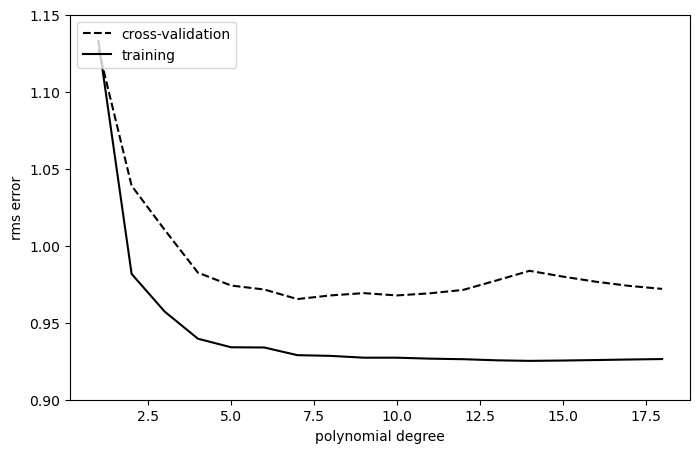

In [9]:
degrees = np.arange(0,18,1)

training_err = np.zeros(degrees.shape)
crossval_err = np.zeros(degrees.shape)
chi2_train = np.zeros(degrees.shape)
chi2_cv = np.zeros(degrees.shape)

fig = plt.figure(figsize=(8, 8))

for i, d in enumerate(degrees):

    regressor = PolynomialRegression(d+1)    
    regressor.fit(x_train, y_train, dmu_train)
    predict_train = regressor.predict(x_train)
    training_err[i] = np.sqrt(np.sum((predict_train  - y_train) ** 2)
                              / len(y_train))
    chi2_train[i] = np.sum(((predict_train  - y_train) / dmu_train) ** 2)
    # Calculate RMS for the CV
    predict_cv = regressor.predict(x_cv)
    crossval_err[i] = np.sqrt(np.sum((predict_cv  - y_cv) ** 2)
                              / len(y_cv))
    chi2_cv[i] = np.sum(((predict_cv  - y_cv) / dmu_cv) ** 2)

# Calculate the BIC = chi2 + (d+1) ln(N) 
#BIC_train = chi2_train[id_train] + (degrees+1) * np.log(len(y_train))
#BIC_crossval = chi2_train[cv] + (degrees+1) * np.log(len(y_cv))

#----------------------------------------------
# PLOT of the LEARNING CURVES
f, ax = plt.subplots(nrows=1, figsize=(8, 5), sharex=True)

#RMS error 
ax.plot(degrees+1, crossval_err, '--k', label='cross-validation')
ax.plot(degrees+1, training_err, '-k', label='training')
ax.plot(degrees+1, 0.1 * np.ones(degrees.shape), ':k')

#ax.set_xlim(0, 18)
ax.set_ylim(0.9, 1.15)
#ax.set_ylim(1.9, 2)

[ax.set_xlabel('polynomial degree') for j in range(2)]; 
ax.set_ylabel('rms error')
ax.legend(loc=2)


In [10]:
#plt.errorbar(x_train_rf, y_train_rf, yerr=dmu_train_rf, ls='', marker='.')
#plt.errorbar(x_cv_rf, y_cv_rf, yerr=dmu_cv_rf, ls='', marker='o')

The best polynomial order is rather around 3 - 4. 

In [11]:
x_train.shape, y_train.shape, x_cv.shape

((700, 1), (700,), (300, 1))

In [112]:
xall.shape, yall.shape, dmu.shape

((1000,), (1000,), (1000,))

In [13]:
# Let's do the same using "train_test_split" 
from sklearn.model_selection import train_test_split
# Let's create fresh variables ... and use COPY of the original data set 
X, y, dy = z_sample[:, np.newaxis].copy(), mu_sample.copy(), dmu.copy()   # I also reshape X 
X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, np.array([y,dy]).T, test_size=0.2, random_state=2)
y_train, dy_train = ydy_train.T
y_cv,dy_cv = ydy_validation.T


In [14]:
# verification that there is no element in common between train and cv
np.intersect1d(X_train, X_validation), np.intersect1d(y_train, y_cv), np.intersect1d(dy_train, dy_cv)

(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64))

In [15]:
ydy_train.shape, ydy_validation.shape, y_train.shape,dy_train.shape, X_train.shape

((800, 2), (200, 2), (800,), (800,), (800, 1))

<ErrorbarContainer object of 3 artists>

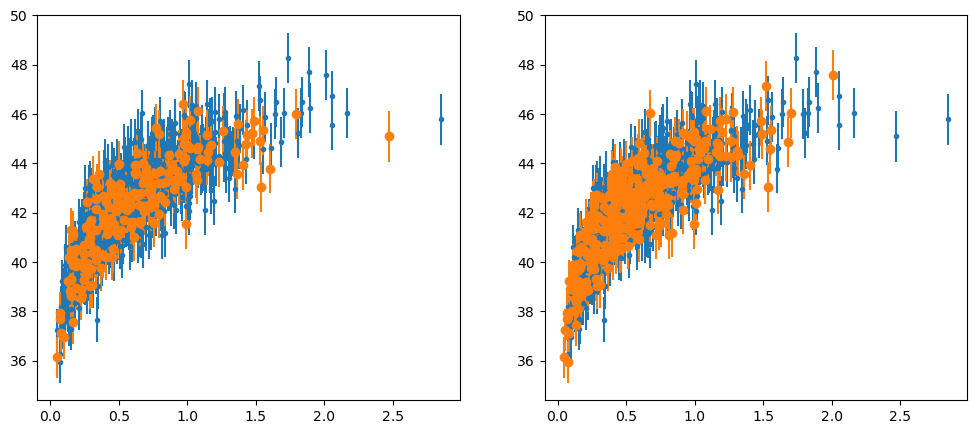

In [16]:
f, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax[0].errorbar(X_train, y_train, yerr=dy_train, ls='', marker='.')
ax[0].errorbar(X_validation, y_cv, yerr=dy_cv, ls='', marker='o')
ax[1].errorbar(x_train_rf, y_train_rf, yerr=dmu_train_rf, ls='', marker='.')
ax[1].errorbar(x_cv_rf, y_cv_rf, yerr=dmu_cv_rf, ls='', marker='o')


In [17]:
X_train.shape, y_train.shape, dy_train.shape

((800, 1), (800,), (800,))

In [18]:
degrees = np.arange(0,18,1)

training_err = np.zeros(degrees.shape)
crossval_err = np.zeros(degrees.shape)
BIC_train = np.zeros(degrees.shape)
BIC_crossval = np.zeros(degrees.shape)
chi2_train = np.zeros(degrees.shape)
chi2_cv = np.zeros(degrees.shape)

for i, d in enumerate(degrees):
    regressor = PolynomialRegression(d+1)    
    regressor.fit(X_train.copy(), y_train.copy(), dy_train.copy())
    predict_train = regressor.predict(X_train)
    training_err[i] = np.sqrt(np.sum((predict_train  - y_train) ** 2) / len(y_train))
    chi2_train[i] = np.sum( ((predict_train  - y_train) / dy_train )** 2.  )
    # Calculate RMS for the CV
    predict_cv = regressor.predict(X_validation)
    crossval_err[i] = np.sqrt(np.sum((predict_cv  - y_cv) ** 2) / len(y_cv))
    chi2_cv[i] = np.sum(((predict_cv  - y_cv) / dy_cv) ** 2)

    BIC_train[i] = chi2_train[i] + (d+1) * np.log(len(y_train))
    BIC_crossval[i] = chi2_cv[i] + (d+1) * np.log(len(y_cv))

In [19]:
BIC_train.min(), BIC_crossval.min()

(np.float64(820.5247891008526), np.float64(237.36245073450544))

(0.0, 870.0)

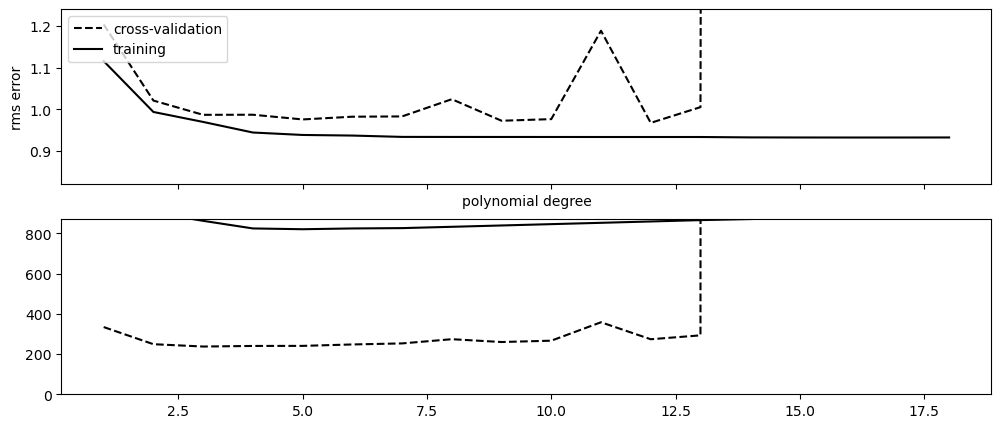

In [20]:
#----------------------------------------------
# PLOT of the LEARNING CURVES
f, ax = plt.subplots(nrows=2, figsize=(12, 5), sharex=True)

#RMS error 
ax[0].plot(degrees+1, crossval_err, '--k', label='cross-validation')
ax[0].plot(degrees+1, training_err, '-k', label='training')
#ax.plot(degrees+1, 0.1 * np.ones(degrees.shape), ':k')

#ax.set_xlim(0, 15)
ax[0].set_ylim(0.82, 1.24)

[ax[0].set_xlabel('polynomial degree') for j in range(2)]; 
ax[0].set_ylabel('rms error')
ax[0].legend(loc=2)
ax[1].plot(degrees+1, BIC_crossval, '--k', label='cross-validation')
ax[1].plot(degrees+1, BIC_train, '-k', label='training')
ax[1].set_ylim(0, 870)

<div class="alert alert-block alert-warning"> 
<b>  Sensibility of the result to the random split between train and CV </b>

For this specific data set, we see some weird / surprising behvior as the training curve appears often ABOVE the CV ... This does not seem to make sense. 
By changing the random seed of the split, we see that in fact, the values of the MSE (and more strongly of the BIC) strongly depend on the random seed / of the sample in hands. The reason why this happens is the fact that we have only VERY FEW DATA POINTS at high z (i.e. z > 2). Those data points have large uncertainties that dramatically increase the MSE for the training BUT as, those points are not often present in the cross validation, the CV gets a better fit than the training !! 

The reason why the BIC is larger for the training and for the CV is different: The sizes of the two samples are not the same ! Because of this, the BIC of the the two samples CANNOT be compared straight away. They can only if we consider the same number of points for the training and the CV. 

</div>

In [21]:
# let's repeat the above exercise removing the data points with z > 1.9 (we see that this is where we have less points)
z_max = 1.9
X, y, dy = z_sample[z_sample < z_max, np.newaxis].copy(), mu_sample[z_sample < z_max].copy(), dmu[z_sample < z_max].copy()   # I also reshape X 
X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, np.array([y,dy]).T, test_size=0.5, random_state=22)
y_train, dy_train = ydy_train.T
y_cv,dy_cv = ydy_validation.T


(0.0, 870.0)

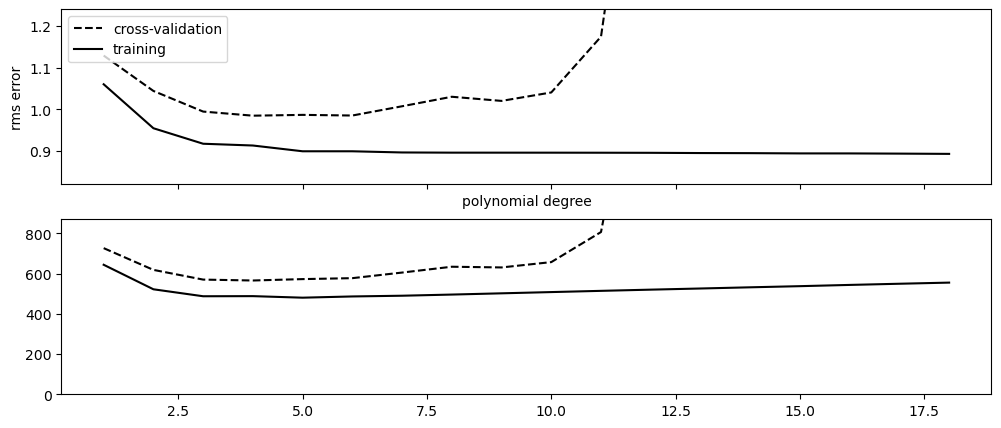

In [22]:
training_err = np.zeros(degrees.shape)
crossval_err = np.zeros(degrees.shape)
BIC_train = np.zeros(degrees.shape)
BIC_crossval = np.zeros(degrees.shape)
chi2_train = np.zeros(degrees.shape)
chi2_cv = np.zeros(degrees.shape)

for i, d in enumerate(degrees):
    regressor = PolynomialRegression(d+1)    
    regressor.fit(X_train.copy(), y_train.copy(), dy_train.copy())
    predict_train = regressor.predict(X_train)
    training_err[i] = np.sqrt(np.sum((predict_train  - y_train) ** 2) / len(y_train))
    chi2_train[i] = np.sum( ((predict_train  - y_train) / dy_train )** 2.  )
    # Calculate RMS for the CV
    predict_cv = regressor.predict(X_validation)
    crossval_err[i] = np.sqrt(np.sum((predict_cv  - y_cv) ** 2) / len(y_cv))
    chi2_cv[i] = np.sum(((predict_cv  - y_cv) / dy_cv) ** 2)

    BIC_train[i] = chi2_train[i] + (d+1) * np.log(len(y_train))
    BIC_crossval[i] = chi2_cv[i] + (d+1) * np.log(len(y_cv))
#----------------------------------------------
# PLOT of the LEARNING CURVES
f, ax = plt.subplots(nrows=2, figsize=(12, 5), sharex=True)

#RMS error 
ax[0].plot(degrees+1, crossval_err, '--k', label='cross-validation')
ax[0].plot(degrees+1, training_err, '-k', label='training')
#ax.plot(degrees+1, 0.1 * np.ones(degrees.shape), ':k')

#ax.set_xlim(0, 15)
ax[0].set_ylim(0.82, 1.24)

[ax[0].set_xlabel('polynomial degree') for j in range(2)]; 
ax[0].set_ylabel('rms error')
ax[0].legend(loc=2)
ax[1].plot(degrees+1, BIC_crossval, '--k', label='cross-validation')
ax[1].plot(degrees+1, BIC_train, '-k', label='training')
ax[1].set_ylim(0, 870)

What about the Basis function regressor? 

In [23]:
n_basis = np.arange(1,20)
training_err_bf = np.zeros(n_basis.shape)
crossval_err_bf = np.zeros(n_basis.shape)

for i, n in enumerate(n_basis):
    basis_mu = np.linspace(0,2,n)[:, None]
    basis_sigma = 3.0 
    
    regressor = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)   
    regressor.fit(X_train, y_train, dy_train)
    predict_train = regressor.predict(X_train)
    training_err_bf[i] = np.sqrt(np.sum((predict_train  - y_train) ** 2) / len(y_train))
    # Calculate RMS for the CV
    predict_cv = regressor.predict(X_validation)
    crossval_err_bf[i] = np.sqrt(np.sum((predict_cv  - y_cv) ** 2) / len(y_cv))

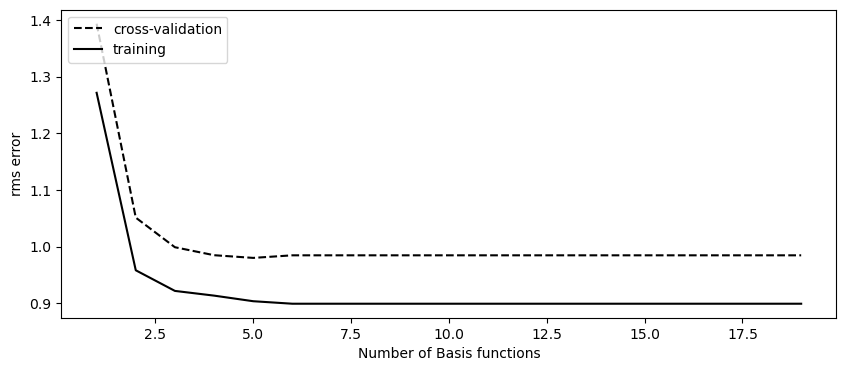

In [24]:
#----------------------------------------------
# PLOT of the LEARNING CURVES
f, ax = plt.subplots(nrows=1, figsize=(10, 4))

#RMS error 
ax.plot(n_basis, crossval_err_bf, '--k', label='cross-validation')
ax.plot(n_basis, training_err_bf, '-k', label='training')
#ax.plot(degrees+1, 0.1 * np.ones(degrees.shape), ':k')

#ax.set_xlim(0, 15)
#ax.set_ylim(0.82, 1.24)

[ax.set_xlabel('Number of Basis functions') for j in range(2)]; 
ax.set_ylabel('rms error')
ax.legend(loc=2)


## Gaussian Process Regression


In [25]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor

In [26]:
#Finding these numbers required some eye-balling
# In practice I took the constant and the RBF separately and multiplied
# kernel = ConstantKernel(1.0, (1e-3, 1e3)) + RBF(10, (1e-2, 1e2))
#kernel = ConstantKernel(1.0, (1e-3, 1e3)) 
#kernel =  ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1.e-1, 10))

# It is even simpler to multiply the kernel by some constant to get a good fit
kernel =  2 * RBF(10, (1e-2, 1e2))
#kernel =  42. + 2 * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, 
                              alpha=dmu ** 2)

gp.fit(z_sample[:, None], mu_sample)
mu_fit, sigma = gp.predict(z[:, None], 
                           return_std=True)
#print(mu_fit, sigma)

(35.0, 50.0)

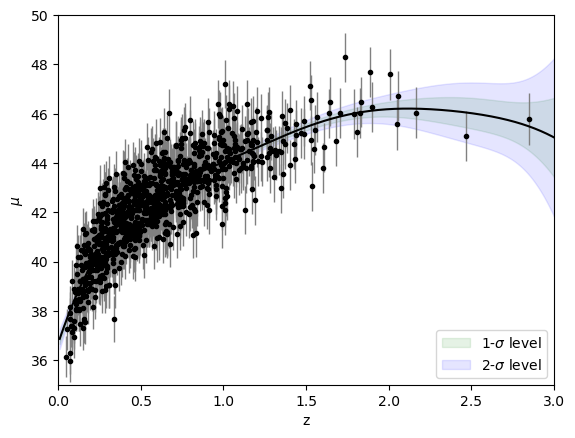

In [27]:
mu_fit = gp.predict(z[:,np.newaxis])

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

plt.plot(z, mu_fit, '-k')

plt.fill_between(z, mu_fit - sigma, 
                mu_fit + sigma,
                alpha=0.1, color='g', 
                label=r'1-$\sigma$ level')

plt.fill_between(z, mu_fit - 2* sigma, 
                mu_fit + 2* sigma,
                alpha=0.1, color='b', 
                label=r'2-$\sigma$ level')

plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.legend(loc='lower right')
plt.xlim(0,3)
plt.ylim(35,50)

Adding a constant yields more wavy variations. Mutliplying the kernel width yields smoother changes. 

The gaussian process seems to deal better with the high z objects. 